Các điểm khó ở dataset và cách nhóm đã xử lý:

- holiday chỉ có 61 giá trị non null: encoding 1 với nhưng ngày lễ (non-null) vì những ngày này lưu lượng xe lớn, 0 với những ngày bình thường (null)

- 17 bản ghi bị duplicate hoàn toàn: drop các cột bị duplicate

- 6521 bản ghi bị duplicate timestamp, nhưng khác nhau ở các feature khác: với các numerical feature lấy mean, với weather_description tính score theo trafic volume rồi lấy mean

- sau khi duplicate, số lượng bản ghi không đầy đủ và không liên tục theo giờ lớn (thiếu 11976 time stamp). Có những bản ghi cách nhau hơn 7000 giờ (tương đương 10 tháng): với những gap nhỏ hơn 24 giờ thì impute, gap lớn sử dụng BreakSequence. BreakSequence cắt dataset thành các block liên tục, slide trên các block này để train/test.

- weather_description chứa các giá trị là các câu và trung lặp với weather_main: bỏ weather_main, encoding weather_description theo giá trị trung bình của traffic_volume (target)

- temp, rain_1h chứa các giá trị không hợp lệ: đưa về giá trị median 

- traffic_volume (target) giao động mạnh (0 - 7000), tùy thuộc theo thời điểm: scaling

In [ ]:
import os
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import optuna

Epoch 1/6 train_loss=0.032370 val_loss=0.010969
Epoch 2/6 train_loss=0.008322 val_loss=0.006615
Epoch 3/6 train_loss=0.005513 val_loss=0.004977
Epoch 4/6 train_loss=0.004845 val_loss=0.004743
Epoch 5/6 train_loss=0.004409 val_loss=0.003564
Epoch 6/6 train_loss=0.004297 val_loss=0.005190
Train Metrics: {'MAE': 341.5887451171875, 'RMSE': np.float64(487.8146420516711), 'NSE': np.float32(0.938274), 'R2': 0.9382728338241577}
Val Metrics: {'MAE': 401.7984619140625, 'RMSE': np.float64(522.303102853123), 'NSE': np.float32(0.92899853), 'R2': 0.9289973378181458}


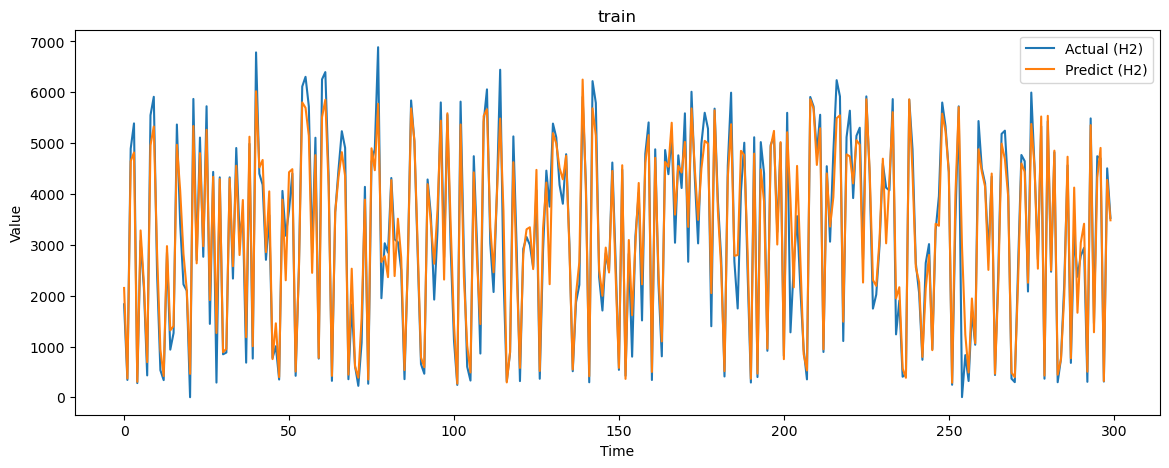

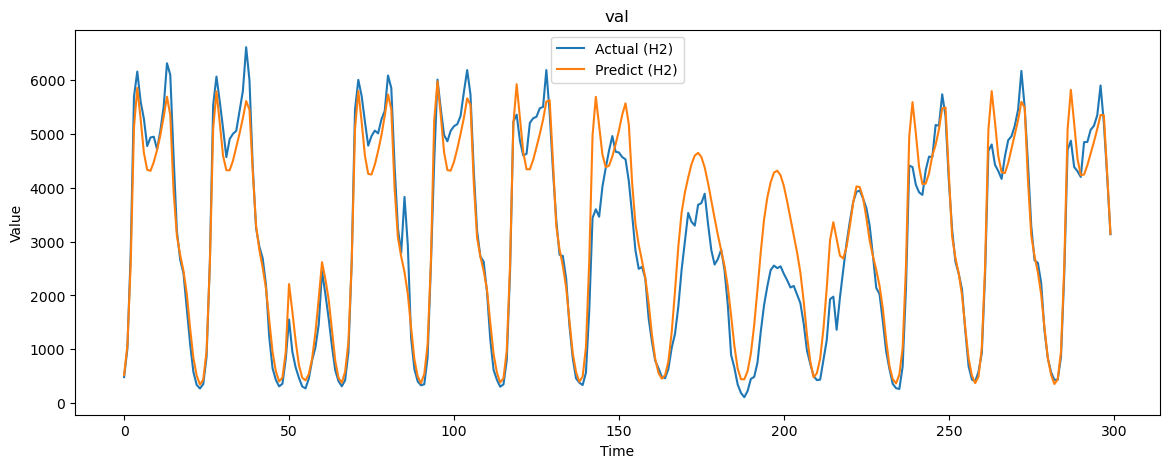

[I 2025-11-29 23:06:49,103] A new study created in memory with name: no-name-037b41fa-3e1d-45eb-81a5-85be872072e7
[I 2025-11-29 23:07:19,874] Trial 0 finished with value: 347.70703125 and parameters: {'hidden_size': 153, 'lr': 0.00047745990058832723, 'batch_size': 32}. Best is trial 0 with value: 347.70703125.
[I 2025-11-29 23:07:43,193] Trial 1 finished with value: 323.23089599609375 and parameters: {'hidden_size': 193, 'lr': 0.0010610154216303177, 'batch_size': 128}. Best is trial 1 with value: 323.23089599609375.
[I 2025-11-29 23:08:06,004] Trial 2 finished with value: 437.60235595703125 and parameters: {'hidden_size': 54, 'lr': 0.00018842560934168907, 'batch_size': 32}. Best is trial 1 with value: 323.23089599609375.
[I 2025-11-29 23:08:19,099] Trial 3 finished with value: 325.25506591796875 and parameters: {'hidden_size': 88, 'lr': 0.00440050101685838, 'batch_size': 128}. Best is trial 1 with value: 323.23089599609375.
[I 2025-11-29 23:08:46,537] Trial 4 finished with value: 327.0

Best trial hyperparams:
{'hidden_size': 245, 'lr': 0.004333136096291239, 'batch_size': 128}
Best MAE: 291.66119384765625
Epoch 1/6 train_loss=0.060367 val_loss=0.013284
Epoch 2/6 train_loss=0.008563 val_loss=0.005297
Epoch 3/6 train_loss=0.005870 val_loss=0.006049
Epoch 4/6 train_loss=0.005076 val_loss=0.005628
Epoch 5/6 train_loss=0.004433 val_loss=0.005297
Epoch 6/6 train_loss=0.004135 val_loss=0.003979

Test Metrics with best params:
{'MAE': 405.1837158203125, 'RMSE': np.float64(541.7682276582856), 'NSE': np.float32(0.9252257), 'R2': 0.9252256751060486}


In [ ]:
class CFG:
    seed = 42
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    SMALL_GAP = 6 
    lookback = 24
    horizon = 2
    epochs = 6
    lr = 1e-3
    models_dir = './models'
    os.makedirs(models_dir, exist_ok=True)

torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)
if CFG.device == 'cuda':
    torch.cuda.manual_seed_all(CFG.seed)

MASK_VALUE = 0.0 

metro_interstate_traffic_volume = fetch_ucirepo(id=492) 
  
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets  

df = X.copy()
df['traffic_volume'] = y.copy()

#  2. Xử lý holiday 
df['holiday'] = df['holiday'].fillna('None')
df['is_holiday'] = (df['holiday'] != 'None').astype(int)
df = df.drop(columns=["holiday"])

#  3. Clean temp và rain 
median_temp = df.loc[df['temp'] > 0, 'temp'].median()
df['temp'] = df['temp'].replace(0, median_temp)

median_rain = df.loc[df['rain_1h'] < 100, 'rain_1h'].median()
df.loc[df['rain_1h'] > 100, 'rain_1h'] = median_rain
df['rain_1h'] = df['rain_1h'].replace(0, median_rain)

#  4. Datetime và group duplicate 
df["date_time"] = pd.to_datetime(df["date_time"])
original_df = df.copy()

numeric_cols = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume"]
first_cols = ["is_holiday"]

df_grouped = df.groupby("date_time").agg(
    {**{c: "mean" for c in numeric_cols},
     **{c: "first" for c in first_cols}}
).reset_index()

#  5. Weather Score (train-based mapping, tránh leakage) 
start = df_grouped['date_time'].min()
end = df_grouped['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq="h") 
train_end_time = full_range[int(0.7 * len(full_range))]

train_rows_for_score = original_df[original_df['date_time'] <= train_end_time]
weather_score_map = train_rows_for_score.groupby('weather_description')['traffic_volume'].mean().to_dict()
global_mean_score = train_rows_for_score['traffic_volume'].mean()

def compute_weather_score_for_ts(ts):
    rows = original_df[original_df['date_time'] == ts]
    if len(rows) == 0:
        return np.nan
    scores = rows['weather_description'].map(lambda x: weather_score_map.get(x, global_mean_score))
    return scores.mean()

weather_scores = df_grouped['date_time'].apply(compute_weather_score_for_ts)
df_grouped['weather_score'] = weather_scores.fillna(global_mean_score)
df_grouped = df_grouped.drop(columns=['weather_main', 'weather_description'], errors='ignore')


#  6. Reindex & interpolate small gaps 
df_full = df_grouped.set_index('date_time').reindex(full_range)
df_full.index.name = 'date_time'

original_exists = df_grouped.set_index('date_time').index
df_full['timestep_mask'] = df_full.index.isin(original_exists).astype(int)

num_cols_to_interp = ["temp", "rain_1h", "snow_1h", "clouds_all", "traffic_volume", "weather_score"]
df_full[num_cols_to_interp] = df_full[num_cols_to_interp].interpolate(
    method='time', limit=CFG.SMALL_GAP, limit_direction='both'
)

# Large gaps vẫn để NaN
df_full[num_cols_to_interp] = df_full[num_cols_to_interp].where(df_full['timestep_mask']==1, np.nan)

# Reset index
df_full = df_full.reset_index()

#  7. Feature Engineering 
df_full["year"] = df_full["date_time"].dt.year
df_full["month"] = df_full["date_time"].dt.month
df_full["day"] = df_full["date_time"].dt.day
df_full["hour"] = df_full["date_time"].dt.hour
df_full["day_of_week"] = df_full["date_time"].dt.dayofweek
df_full["is_weekend"] = (df_full["day_of_week"] >= 5).astype(int)
df_full["is_rain"] = (df_full["rain_1h"] > 0).astype(int)
df_full["is_snow"] = (df_full["snow_1h"] > 0).astype(int)

# Cyclical encoding
df_full["hour_sin"] = np.sin(2*np.pi*df_full["hour"]/24)
df_full["hour_cos"] = np.cos(2*np.pi*df_full["hour"]/24)
df_full["dow_sin"] = np.sin(2*np.pi*df_full["day_of_week"]/7)
df_full["dow_cos"] = np.cos(2*np.pi*df_full["day_of_week"]/7)
df_full["month_sin"] = np.sin(2*np.pi*df_full["month"]/12)
df_full["month_cos"] = np.cos(2*np.pi*df_full["month"]/12)
df_full["trend"] = np.arange(len(df_full))
week_hour = df_full['day_of_week']*24 + df_full['hour']
df_full['sin_168'] = np.sin(2*np.pi*week_hour/168)
df_full['cos_168'] = np.cos(2*np.pi*week_hour/168)
df_full["fourier_sin_year"] = np.sin(2*np.pi*df_full["trend"]/(365*24))
df_full["fourier_cos_year"] = np.cos(2*np.pi*df_full["trend"]/(365*24))

#  8. Scaling 
feature_cols = [
    "temp","rain_1h","clouds_all","snow_1h","is_holiday","weather_score",
    "year","month","day","hour","day_of_week","is_weekend","is_rain","is_snow",
    "hour_sin","hour_cos","dow_sin","dow_cos","month_sin","month_cos",
    "trend","sin_168","cos_168","fourier_sin_year","fourier_cos_year"
]

X_all = df_full[feature_cols].values.astype(np.float32)
y_all = df_full[['traffic_volume']].values.astype(np.float32)
mask_all = df_full['timestep_mask'].values

total_len = len(X_all)
train_end_idx = int(0.7 * total_len)
val_end_idx   = int(0.8 * total_len)

X_train_raw = X_all[:train_end_idx]
X_val_raw   = X_all[train_end_idx:val_end_idx]
X_test_raw  = X_all[val_end_idx:]

y_train_raw = y_all[:train_end_idx]
y_val_raw   = y_all[train_end_idx:val_end_idx]
y_test_raw  = y_all[val_end_idx:]

mask_train = mask_all[:train_end_idx]
mask_val   = mask_all[train_end_idx:val_end_idx]
mask_test  = mask_all[val_end_idx:]

# Fit ONLY on TRAIN 
scaler_X = MinMaxScaler()
scaler_X.fit(X_train_raw)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_raw)

# Transform Train/Val/Test 
X_train = scaler_X.transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

#  10. Dataset Break the Sequence 
def get_blocks(mask):
    # mask = 1/0
    mask = np.array(mask)
    padded = np.r_[0, mask, 0]
    diff = np.diff(padded)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return list(zip(starts, ends))  

class BreakSequenceDataset(Dataset):
    def __init__(self, X, y, mask, lookback, horizon):
        self.lookback = lookback
        self.horizon = horizon
        self.samples = []

        X, y, mask = np.array(X), np.array(y), np.array(mask)
        for start, end in get_blocks(mask):
            L = end - start
            if L < lookback + horizon:
                continue
            for i in range(start, end - lookback - horizon + 1):
                x_seq = X[i:i+lookback]
                y_seq = y[i+lookback:i+lookback+horizon]
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y.reshape(-1), dtype=torch.float32)

train_ds = BreakSequenceDataset(X_train, y_train, mask_train, CFG.lookback, CFG.horizon)
val_ds   = BreakSequenceDataset(X_val, y_val, mask_val, CFG.lookback, CFG.horizon)
test_ds  = BreakSequenceDataset(X_test, y_test, mask_test, CFG.lookback, CFG.horizon)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False)

#  11. Model 
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden, horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden, batch_first=True)
        self.head = nn.Linear(hidden, horizon)
    def forward(self, x):
        out, _ = self.lstm(x)
        out_last = out[:, -1, :]
        return self.head(out_last)

# TRAIN LOOP
def train_loop(model, train_loader, val_loader, epochs=6, lr=1e-3):
    device = torch.device(CFG.device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float('inf')
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_losses.append(criterion(pred, yb).item())
        avg_tr, avg_val = np.mean(train_losses), np.mean(val_losses)
        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
        print(f'Epoch {ep}/{epochs} train_loss={avg_tr:.6f} val_loss={avg_val:.6f}')

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# EVALUATION
def evaluate_model(model, loader, scaler_y, eps=1e-3):
    device = torch.device(CFG.device)
    model.eval()

    Ys = []
    Ps = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb)        
            Ys.append(yb.numpy())     
            Ps.append(pred.cpu().numpy())

    Y = np.vstack(Ys)                
    P = np.vstack(Ps)                

    Y_inv = scaler_y.inverse_transform(Y)
    P_inv = scaler_y.inverse_transform(P)

    mae  = mean_absolute_error(Y_inv, P_inv)
    rmse = np.sqrt(mean_squared_error(Y_inv, P_inv))
    r2 = r2_score(Y_inv, P_inv)
    #NSE 
    numerator = np.sum((Y_inv - P_inv)**2)
    denominator = np.sum((Y_inv - np.mean(Y_inv))**2) + eps
    nse = 1 - numerator / denominator


    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "NSE": nse,
        "R2": r2
    }
    return metrics, Y_inv, P_inv

model = SimpleLSTM(input_dim=X_train.shape[1], hidden=128, horizon=CFG.horizon)
model = train_loop(model, train_loader, val_loader, epochs=CFG.epochs, lr=CFG.lr)

metrics_train, Y_train_inv, P_train_inv = evaluate_model(model, train_loader, scaler_y)
metrics_val,   Y_val_inv,   P_val_inv   = evaluate_model(model, val_loader, scaler_y)
metrics_test,  Y_test_inv,  P_test_inv  = evaluate_model(model, test_loader, scaler_y)   

print("Train Metrics:", metrics_train)
print("Val Metrics:", metrics_val)

def plot_horizon2(Y, P, chart_name, max_points=300):
    N = min(len(Y), max_points)

    plt.figure(figsize=(14, 5))
    plt.plot(Y[:N, 1], label='Actual (H2)')
    plt.plot(P[:N, 1], label='Predict (H2)')
    plt.title(f'{chart_name}')
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

metrics, Y_inv, P_inv = evaluate_model(model, test_loader, scaler_y)

plot_horizon2(Y_train_inv, P_train_inv, 'train')
plot_horizon2(Y_val_inv, P_val_inv, 'val')

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])

    # DataLoaders 
    train_loader_opt = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader_opt   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Model 
    model = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=2).to(CFG.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")

    EPOCHS_OPT = 6
    for ep in range(EPOCHS_OPT):
        model.train()
        for xb, yb in train_loader_opt:
            xb, yb = xb.to(CFG.device), yb.to(CFG.device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # Validation 
        model.eval()
        Ys, Ps = [], []
        with torch.no_grad():
            for xb, yb in val_loader_opt:
                xb = xb.to(CFG.device)
                pred = model(xb)
                Ys.append(yb.cpu().numpy())
                Ps.append(pred.cpu().numpy())

        Y_val = np.vstack(Ys)
        P_val = np.vstack(Ps)

        # Inverse scaling
        Y_val_inv = scaler_y.inverse_transform(Y_val)
        P_val_inv = scaler_y.inverse_transform(P_val)

        val_mae = mean_absolute_error(Y_val_inv, P_val_inv)

        trial.report(val_mae, ep)

        if val_mae < best_val_loss:
            best_val_loss = val_mae

        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) 

print("Best trial hyperparams:")
print(study.best_trial.params)
print("Best MAE:", study.best_trial.value)

best_params = study.best_trial.params
hidden_size = best_params["hidden_size"]
lr          = best_params["lr"]
batch_size  = best_params["batch_size"]

train_loader_best = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader_best   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader_best  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Model final
model_best = SimpleLSTM(input_dim=X_train.shape[1], hidden=hidden_size, horizon=2)
model_best = train_loop(model_best, train_loader_best, val_loader_best, epochs=CFG.epochs, lr=lr)

# Evaluate Test
metrics_test, Y_test_inv, P_test_inv = evaluate_model(model_best, test_loader_best, scaler_y)
print("\nTest Metrics with best params:")
print(metrics_test)